# A Guide to Resource Estimation for Quantum Chemical Hamiltonians

<p style="text-align: center;"><a href="mailto:fmalone@google.com">Fionn Malone</a></p>

A key feature of Qualtran is the ability to implement, inspect, and cost out fault tolerant algorithms. One area which has received considerable attention over recent years is the development of improved fault tolerant algorithms for simulating problems relevant to chemistry applications. For many applications in chemistry we are only concerned with finding the ground state of the many-electron Hamiltonian. The ground state can be computed using [phase esimation](../phase_estimation/phase_estimation_of_quantum_walk.ipynb) of a [walk operator](../qubitization/qubitization_walk_operator.ipynb).

To construct a walk operator we start by representing the Hamiltonian as a linear combination of unitaries (LCU)
$$
    H = \sum_{l=0}^{L-1} w_l H_l,
$$
where $w_l \ge 0$, $w_l \in \mathbb{R}$, $H_l$ is unitary, and $\lambda = \sum_l w_l$. With this representation we next define two oracles with the following action
$$
    \mathrm{PREPARE} |0\rangle_a = \sum_l \sqrt{\frac{w_l}{\lambda}} |l\rangle_a,
$$
and
$$
    \mathrm{SELECT} |l\rangle_a|\psi\rangle_s = |l\rangle_a U_l |\psi\rangle_s,
$$
where the subscripts $a$ and $s$ signify ancilla and system registers respectively. Note that these oracles **block encode** the Hamiltonian, as
$$
_a\langle 0| _s\langle \psi |\mathrm{PREPARE}^\dagger \cdot \mathrm{SELECT} \cdot \mathrm{PREPARE}  |0\rangle_a |\psi\rangle_s = \frac{1}{\lambda}\sum_{l} w_l H_L = \frac{H}{\lambda}
$$
Similarly, the walk operator can be formed by through a combination of SELECT, PREPARE, $\mathrm{PREPARE}^{\dagger}$ and a reflection about zero.  

The total cost of phase estimation is determined by the cost of constructing SELECT and PREPARE, and the number of iterations ($\mathcal{I}$) (or queries) required to obtain the energy to a given precision $\Delta E$, which is typically take to be about $1\times10^{-3}$ Hartree. The number of iterations is given as
$$
\mathcal{I} = \frac{\pi \lambda}{2 \Delta E}.
$$
[OpenFermion](https://github.com/quantumlib/OpenFermion) provides routines for computing $\lambda$ for the different variations of second quantized Hamiltonians implemented in Qualtran, while we can use Qualtran to construct SELECT and PREPARE. 

In this tutorial we will provide an overview of how to cost out phase estimation for quantum chemical algorithms using Qualtran.  

## Second Quantized Hamiltonians 

Before costing out algorithms, first recall that the Born-Oppenheimer Hamiltonian describing a system of electrons and static nuclei is written in second quantization as 
$$
H = \sum_\sigma \sum_{pq}^{N/2} T_{pq} a_{p\sigma}^\dagger a_{q\sigma}
+
\frac{1}{2}\sum_{\alpha\beta}
\sum_{pqrs}^{N/2}
V_{pqrs} a_{p\alpha}^\dagger a_{q\alpha} a_{r\beta}^\dagger a_{s\beta} ,
$$
where $a_{p\sigma}$ ($a_{q\sigma}^\dagger$) annihilate (create) an electron in the
$p$-th orbital of spin $\sigma$. The $V_{pqrs}$ tensor contains $O(N^4)$ elements and represents a bottleneck for block encoding second quantized Hamiltonians.

To get an idea for why this form of the Hamiltonian is problematic, consider a very naive block encoding of $H$. Following some algebra (reordering the creation and annihilation operators and mapping to Paulis using the Jordan Wigner transformation), we could attempt to use a [generic state preparation](../state_preparation.ipynb) routine to load the Hamiltonian coefficients. This would have complexity of $\mathcal{O}(N^4)$ Toffolis which arises from using QROM to load the data for state preparation. This complexity could be reduced using [QROAM](../select_swap_qrom.py) at the cost of $\mathcal{O}(N^2)$ additional ancilla. The select operation has a cost proportional to $N$ in this case, so we see PREPARE would dominate the complexity.

In recent years there has been a focus on reducing this complexity through using different factorizations of the electron repulsion integral tensor (ERI) $V_{pqrs} \equiv (pq|rs)$. A summary of these methods is given in the table below:

| Name | $$V_{pqrs} $$ | Space complexity |
| :---- | :---- | :---- | 
| [Sparse](sparse/sparse.ipynb)   | $$\tilde{V}_{pqrs}$$ | $$O(N^3)$$ |
| [Single Factorization](sf/single_factorization.ipynb) | $$\sum_X^{L} L_{pq}^X L_{rs}^X $$ | $$O(N^3)$$ |
| [Double Factorization](df/double_factorization.ipynb) | $$\sum_X^{} \left(\sum_k^{\Xi} U^{X}_{pk}f_k^X U_{qk}^{X*}\right)^2$$ | $$O(N^2\Xi)$$ |
| [Tensor Hypercontraction](thc/thc.ipynb) | $$\sum_{\mu\nu}^{M} \chi_p^{\mu}\chi_q^{\mu}\zeta_{\mu\nu}\chi_r^\nu\chi_s^\nu$$ | $$O(N^2)$$ |

where the space complexity column represents the amount of classical data ($\Gamma$, say) required to specify the Hamiltonian. The Toffoli complexity for state preparation for all of these approaches goes roughly like $\sqrt{\Gamma}$. 

## Block Encoding Bloqs

We saw above that the cost of constructing the walk operator is essentially the same as the cost of block encoding our Hamiltonian (up to a reflection). So, for convenience, let us instead consider the cost of block encoding our chemistry Hamiltonians. Qualtran provides a high level [BlockEncodingBloq](../block_encoding.ipynb) for this purpose. We will consider the tensor hypercontraction (THC) algorithm as an example.

In [1]:
import numpy as np
from qualtran.bloqs.chemistry.thc import SelectTHC, PrepareTHC

# Let's just generate some random coefficients for the moment with parameters
# corresponding to the FeMoCo model complex.
num_spin_orb = 108
num_mu = 350
num_bits_theta = 16
num_bits_state_prep = 10
tpq = np.random.normal(0, 1, size=(num_spin_orb//2, num_spin_orb//2))
zeta = np.random.normal(0, 1, size=(num_mu, num_mu))
zeta = 0.5 * (zeta + zeta.T)
eta = np.random.normal(0, 1, size=(num_mu, num_spin_orb//2))
eri_thc = np.einsum("Pp,Pr,Qq,Qs,PQ->prqs", eta, eta, eta, eta, zeta, optimize=True)
# In practice one typically uses the exact ERI tensor instead of that from THC, but that's a minor detail.
tpq_prime = tpq - 0.5 * np.einsum("illj->ij", eri_thc, optimize=True) + np.einsum("llij->ij", eri_thc, optimize=True)
t_l = np.linalg.eigvalsh(tpq_prime)
# Build Select and Prepare
prep_thc = PrepareTHC.from_hamiltonian_coeffs(t_l, eta, zeta, num_bits_state_prep=num_bits_state_prep)
sel_thc = SelectTHC(num_mu, num_spin_orb, num_bits_theta=num_bits_theta, keep_bitsize=prep_thc.keep_bitsize, kr1=16, kr2=16)

In [2]:
from qualtran.bloqs.block_encoding import LCUBlockEncoding
from qualtran.bloqs.multiplexers.black_box_select import BlackBoxSelect
from qualtran.bloqs.state_preparation.black_box_prepare import BlackBoxPrepare

epsilon = 1e-4  # choosing this arbitrarily at this point. See: https://github.com/quantumlib/Qualtran/issues/985
block_encoding_bloq = LCUBlockEncoding(
    select=BlackBoxSelect(sel_thc), prepare=BlackBoxPrepare(prep_thc)
)

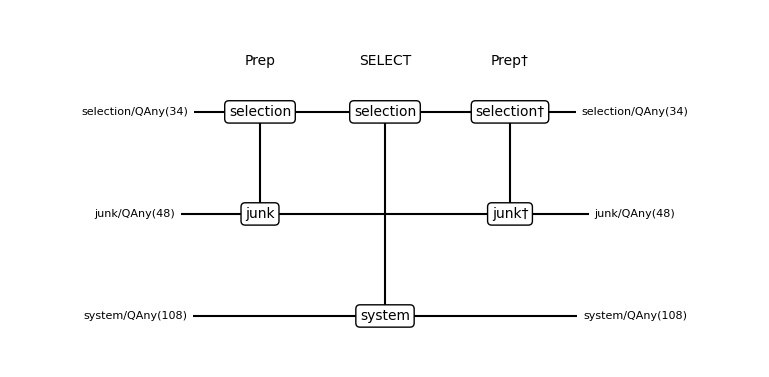

In [3]:
import matplotlib.pyplot as plt
from qualtran.drawing.musical_score import get_musical_score_data, draw_musical_score
msd = get_musical_score_data(block_encoding_bloq.decompose_bloq())
fig, ax = draw_musical_score(msd)
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
fig.set_size_inches(8, 4)

This looks like our math expression above. Now given our block encoding block we can determine the resources required as follows

In [4]:
from qualtran.resource_counting import get_bloq_call_graph
import attrs
from qualtran.bloqs.bookkeeping import Partition, Split, Join, Allocate, Free
from qualtran.bloqs.basic_gates import CSwap, TGate
from qualtran.drawing import show_call_graph

def keeper(bloq):
    # intercept CSwaps which are lumped in with Toffolis in the reference papers
    if isinstance(bloq, CSwap):
        return True
    return False

def generalizer(bloq):
    if isinstance(bloq, (Partition, Split, Join, Allocate, Free)):
        return None
    return bloq


def get_toffoli_counts(bloq):
    _, sigma = get_bloq_call_graph(bloq, generalizer=generalizer, keep=keeper)
    toffolis = 0
    for k, v in sigma.items():
        if isinstance(k, CSwap):
            toffolis += v * k.bitsize
        elif isinstance(k, TGate):
            toffolis += v // 4
    return toffolis

num_toff = get_toffoli_counts(block_encoding_bloq)
# note the cost here is from openfermion, the reference number excludes the reflection
print(f'qualtran = {num_toff} vs. ref = 10880, delta = {num_toff - 10880}')

qualtran = 17894 vs. ref = 10880, delta = 7014


We see that our bloq is pretty close to the quoted result, with the difference being around 300 Toffolis. For some insight into the source of differences see the [THC notebook](thc/thc.ipynb). Typically we may expect some small differences with quoted literature results, with Qualtran hopefully providing the more accurate result!

Now, for this algorithm we might wonder: what are the dominant sources of this cost? Is this cost large? How do other factorizations of the ERIs fares? A natural place to start is comparing select and prepare.

In [5]:
toffoli_counts = [get_toffoli_counts(b) for b in [sel_thc, prep_thc, prep_thc.adjoint()]]
print(toffoli_counts)

[226, 8834, 8834]


([<matplotlib.patches.Wedge at 0x7f13d1b07910>,
 [Text(1.0991342201641756, 0.04363445959433491, 'SELECT'),
  Text(-0.06543023139329489, 1.0980523142454643, 'PREPARE'),
  Text(0.021821552960556236, -1.0997835331675, 'PREPARE$^{\\dagger}$')],
 [Text(0.5995277564531867, 0.023800614324182675, '1.3%'),
  Text(-0.03568921712361539, 0.5989376259520713, '49.4%'),
  Text(0.011902665251212492, -0.5998819271822727, '49.4%')])

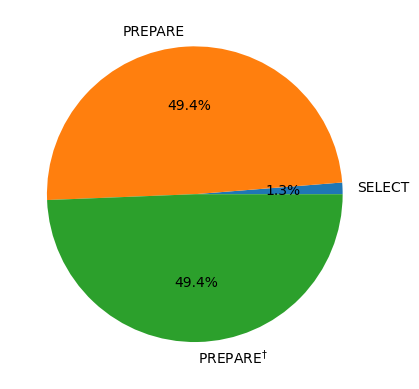

In [6]:
plt.pie(toffoli_counts, labels=['SELECT', 'PREPARE', r'PREPARE$^{\dagger}$'], autopct='%1.1f%%')

We see SELECT is the dominant cost and the inverse state preparation is significantly more expensive than its inverse. Let's have a look at the circuits to see where the costs are coming from.

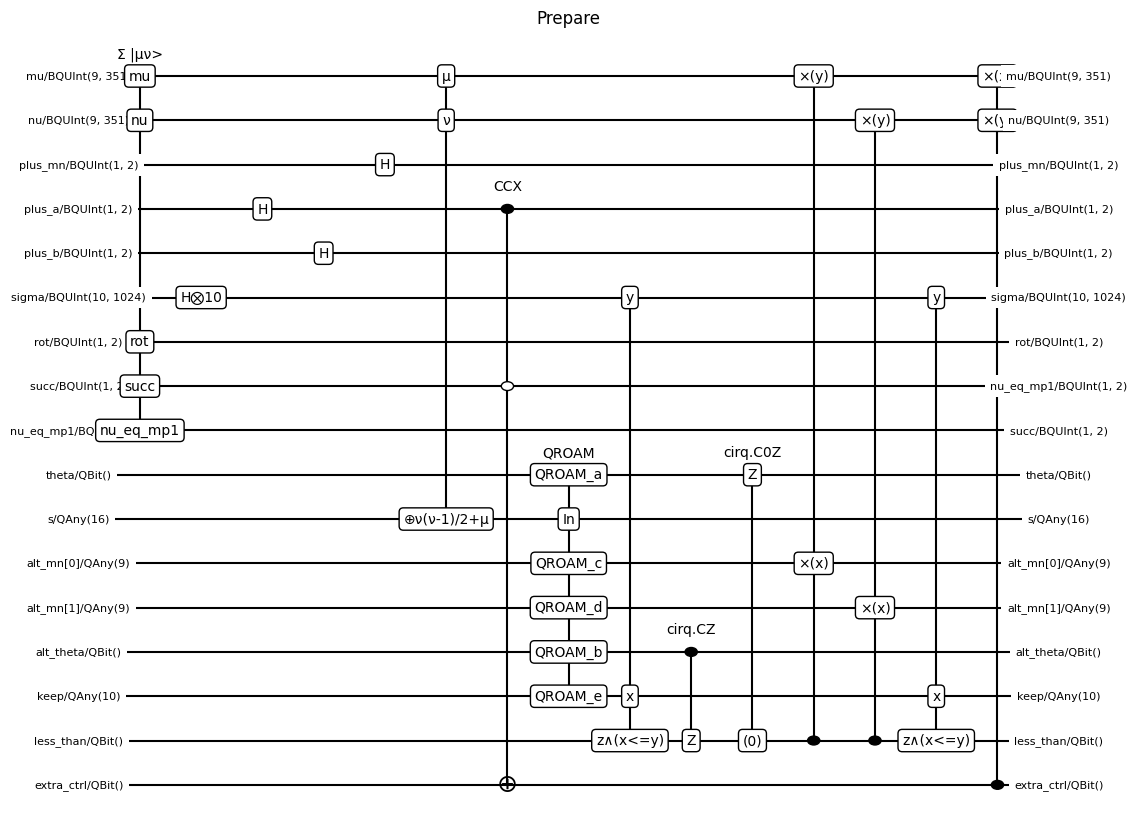

In [7]:
msd = get_musical_score_data(prep_thc.decompose_bloq())
fig, ax = draw_musical_score(msd)
fig.set_size_inches(12, 8)
ax.set_title('Prepare')
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

This figure should resemble Fig. 4 in the [THC paper](https://arxiv.org/abs/2011.03494). This circuit takes a familiar form, uniform state preparation followed by coherent alias sampling (QROM + swaps). Let's see a breakdown of these costs.

In [8]:
from qualtran.resource_counting.classify_bloqs import classify_t_count_by_bloq_type
costs = classify_t_count_by_bloq_type(prep_thc)

/tmp/ipykernel_3236406/1279726884.py:10: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  ax.legend(handles, labels=labels, prop={'size': 10},


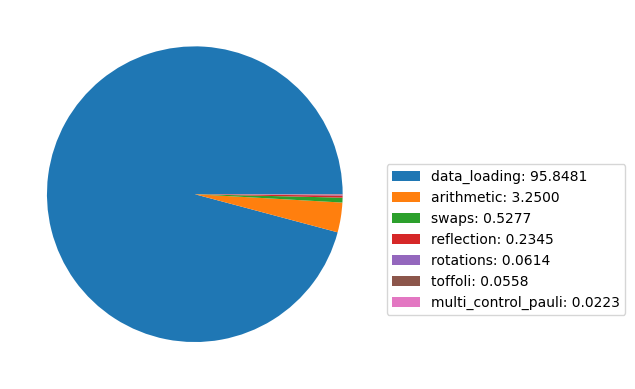

In [9]:
fig, ax = plt.subplots()
values = np.array(list(costs.values()))
ix = np.argsort(values)[::-1]
values = values[ix]
handles = np.arange(len(costs.values()))
keys = np.array(list(costs.keys()))[ix]
norm = sum(values)
labels = [f'{l}: {100*v/norm:3.4f}' for l, v in zip(keys, values)]
plt.pie(values)
ax.legend(handles, labels=labels, prop={'size': 10},
          bbox_to_anchor=(1.0, 0.60))

Roughly 94% of the cost is from the QROM, the other costs being mostly negligible.

Let's now look at SELECT

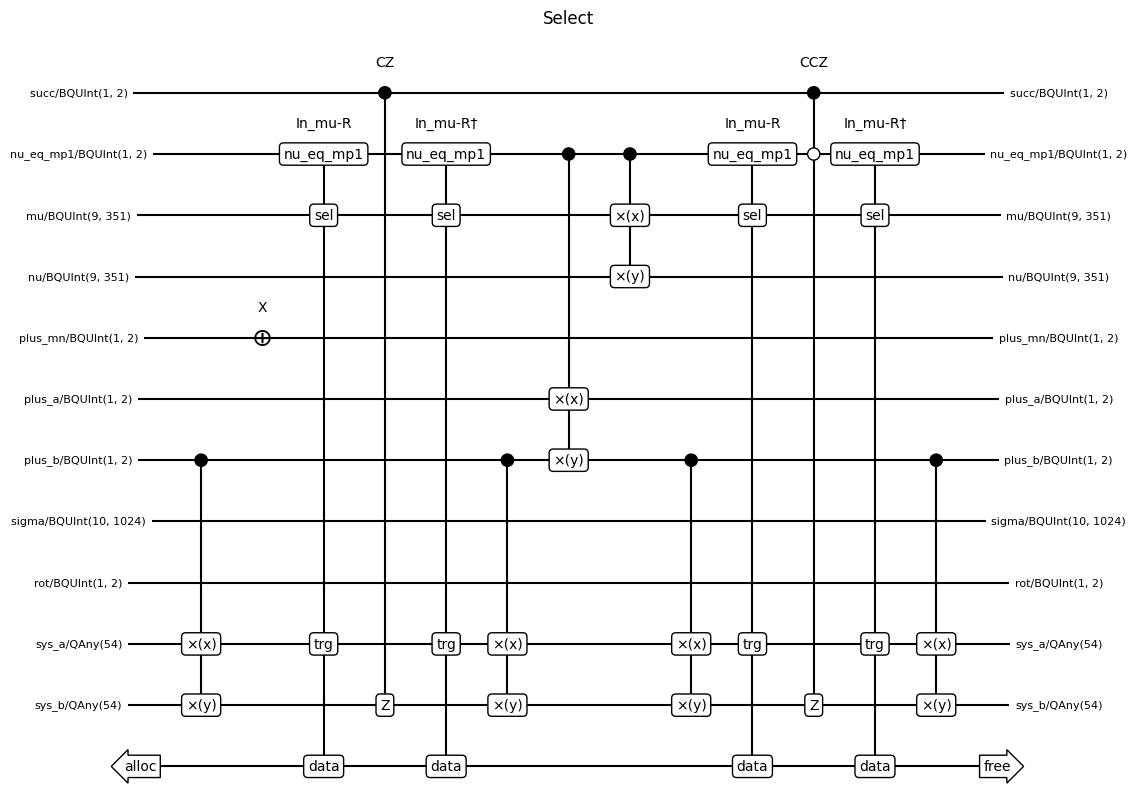

In [10]:
msd = get_musical_score_data(sel_thc.decompose_bloq())
fig, ax = draw_musical_score(msd)
fig.set_size_inches(12, 8)
ax.set_title('Select')
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

Note that the swaps at the beginning and end of SELECT from Fig. 7 are included as part of Prepare. We see that SELECT only contains swaps and something called In-mu-R, which implements the rotations. Let's take a look at that bloq.

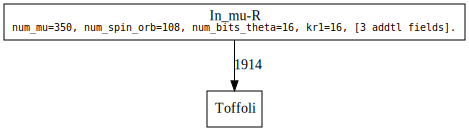

rotation cost = 1512, qrom cost = 402


In [11]:
from qualtran.bloqs.chemistry.thc.select_bloq import THCRotations

bloq = THCRotations(num_mu, num_spin_orb, num_bits_theta, kr1=16, kr2=16)
graph, sigma = bloq.call_graph()
show_call_graph(graph)
print(f"rotation cost = {108 * 14}, qrom cost = {402}")

Unfortunately right now we don't get much insight into the cost breakdown from the diagram, but we know that the dominant cost arise from applying the rotations, which are more than 3 times as expensive as outputting the rotation angles. Check back soon for a more detailed decomposition.

## Other Hamiltonians

The next best factorization is the double factorized Hamiltonian, let's take a look at it. Note in this case we have directly constructed the block encoding rather than providing Select and Prepare primitives.

In [12]:
from qualtran.bloqs.chemistry.df.double_factorization import DoubleFactorizationBlockEncoding

# papameters for the FeMoCo hamiltonian
num_aux = 360
num_eig = 13031
df_bloq = DoubleFactorizationBlockEncoding(num_spin_orb, num_aux, num_eig, num_bits_state_prep, num_bits_rot=num_bits_theta)

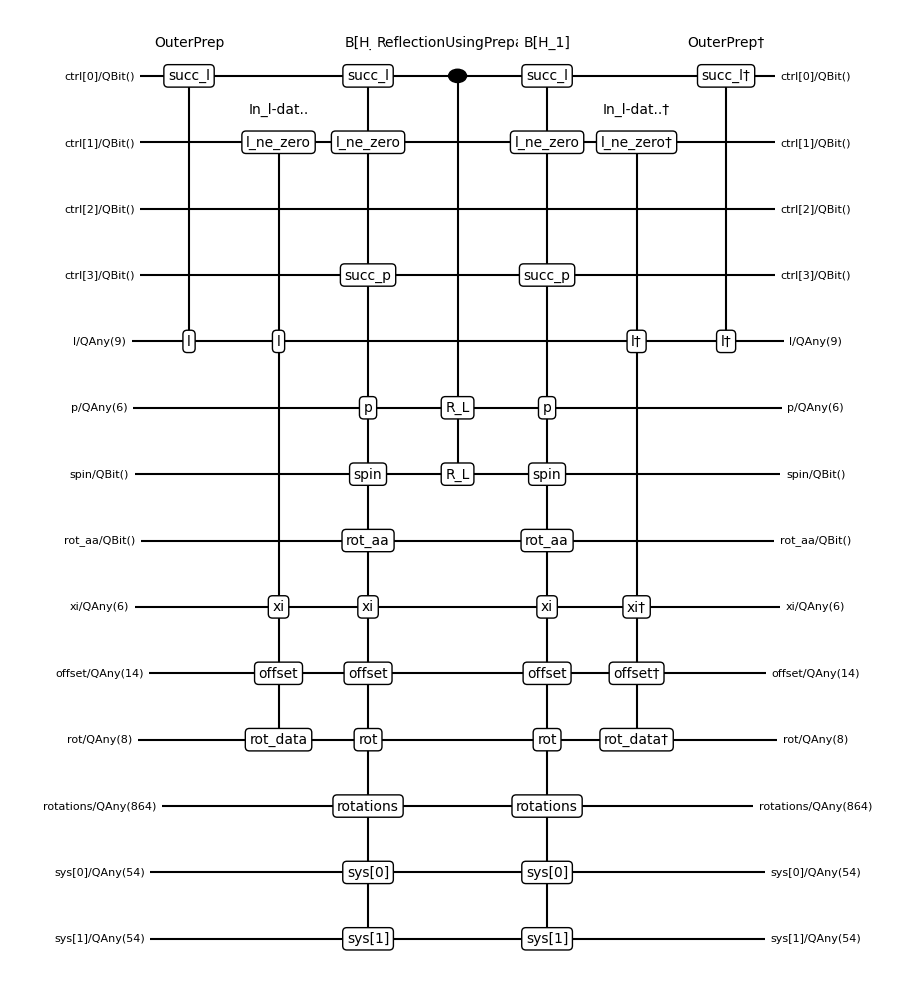

In [13]:
msd = get_musical_score_data(df_bloq.decompose_bloq())
fig, ax = draw_musical_score(msd)
fig.set_size_inches(10, 10)
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

This should resemble(!) Fig 16 in [the THC reference](https://arxiv.org/abs/2011.03494). Feel free to inspect the bloqs!

In [14]:
_, sigma = df_bloq.call_graph()
refl_cost_and_qpe = (df_bloq.num_aux -1).bit_length() + (num_spin_orb // 2 - 1).bit_length() + num_bits_state_prep + 1 + 2
print(f'qualtran cost = {sigma[TGate()] // 4} vs paper = {21753 - refl_cost_and_qpe}')

qualtran cost = 110 vs paper = 21725


## First Quantization

Qualtran also provides bloqs implementing the [first quantized Hamiltonian](pbc/first_quantization/first_quantization.ipynb) representation of the Hamiltonian. Let's build our block encoding again and inspect the dominant costs as a function of the number of electrons ($\eta$). 

In [15]:
def volume_from_rs_eta(rs: float, eta: int) -> float:
    """Get the system volume from fixed rs and electron count eta.

    Args:
        rs: The electron density parameter.
        eta: The number of electrons

    Returns:
        volume: The volume of the cell in bohr.
    """
    volume = (rs**3.0) * (4.0 * np.pi * eta / 3)
    return volume

In [16]:
def approximate_alpha_first_quantization(vol: float, eta: int, num_bits_p: int) -> float:
    """Compute a very rough estimate of the first quantized one-norm.

    Args:
        vol: The volume of the simulation cell.
        eta: The number of electrons.
        num_bits_p: The number of bits for representing the basis.

    References:
    [Fault-Tolerant Quantum Simulations of Chemistry in First Quantization](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.040332)
        Eq. 25.
    """
    # simple cubic simulation_cell
    num_pw = (2**num_bits_p - 1) ** 3
    lambda_t = 6 * eta * np.pi**2 / (vol**(2.0/3.0)) * (2**(num_bits_p - 1) - 1)**2
    lambda_u = eta**2 * (num_pw  / vol)**(1.0/3.0)
    lambda_v = eta**2 * (num_pw / vol)**(1.0/3.0)
    return lambda_t + lambda_u + lambda_v

In [17]:
from qualtran.bloqs.chemistry.pbc.first_quantization.select_and_prepare import (
    SelectFirstQuantization,
    PrepareFirstQuantization,
)

# keep the electron count small to make the diagrams nicer
rs = 3.0
eta = 3.5  # rough value for simple solids.
# The number of bits for representing the basis (in each spatial dimension)
# => The number of planewaves in each dimension, N_x = 2^num_bits_p - 1, and the
# total number of planewaves is N = N_x N_y N_z
num_bits_p = 6
vol = volume_from_rs_eta(rs, eta)
# Assume hydrogen here so zeta = 1
alpha = approximate_alpha_first_quantization(vol, eta, num_bits_p)
prep_fq = PrepareFirstQuantization(num_bits_p, eta, eta, eta, sum_of_l1_coeffs=alpha)
sel_fq = SelectFirstQuantization(num_bits_p, eta, eta, eta)
block_encoding_bloq = LCUBlockEncoding(
    select=BlackBoxSelect(sel_fq), prepare=BlackBoxPrepare(prep_fq)
)

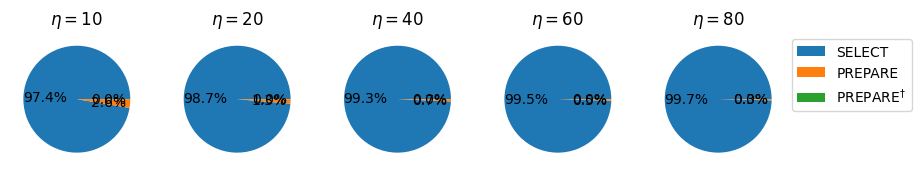

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=5)
for ieta, eta in enumerate([10, 20, 40, 60, 80]):
    vol = volume_from_rs_eta(rs, eta)
    alpha = approximate_alpha_first_quantization(vol, eta, num_bits_p)
    prep_fq = PrepareFirstQuantization(num_bits_p, eta, eta, eta, sum_of_l1_coeffs=alpha)
    sel_fq = SelectFirstQuantization(num_bits_p, eta, eta, eta)
    block_encoding_bloq = LCUBlockEncoding(select=BlackBoxSelect(sel_fq), prepare=BlackBoxPrepare(prep_fq))
    toffoli_counts = [get_toffoli_counts(b) for b in [sel_fq, prep_fq, prep_fq.adjoint()]]
    ax[ieta].set_title(rf'$\eta = {eta}$')
    ax[ieta].pie(toffoli_counts, autopct='%1.1f%%')
ax[-1].legend(labels=['SELECT', 'PREPARE', r'PREPARE$^{\dagger}$'], loc='best', bbox_to_anchor=(2, 1))
fig.set_size_inches(10, 6)

Interesting! We see that as $\eta$ grows the cost of SELECT dominates. Let's inspect the circuit to see what is the source of the dominant cost.

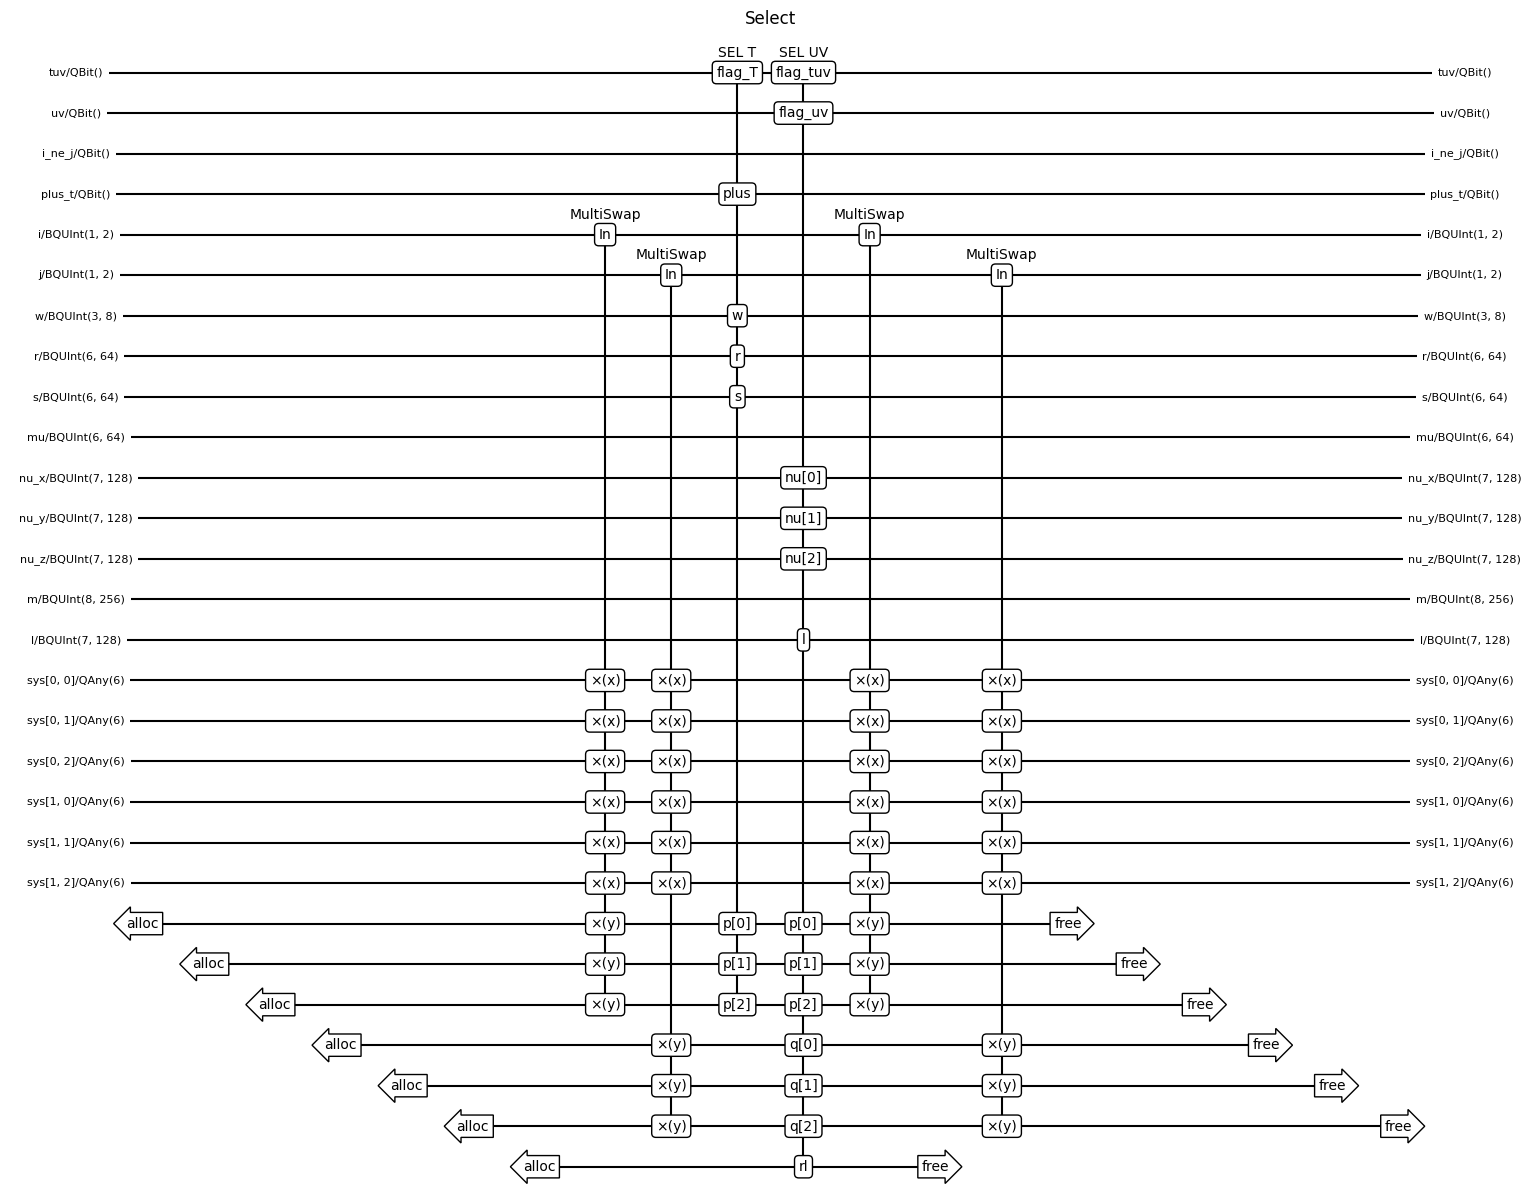

In [19]:
msd = get_musical_score_data(attrs.evolve(sel_fq, eta=2).decompose_bloq())
fig, ax = draw_musical_score(msd)
fig.set_size_inches(18, 12)
ax.set_title('Select')
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

We see that there are only 3 components, a multiplexed swap, a SELECT operation for the kinetic energy and a SELECT for the potential energy terms. Let's inspect the scaling of these costs with the system size again.

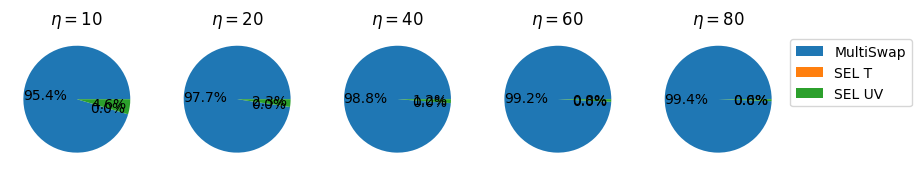

In [20]:
# let's just get the names of the relevant bloqs in select first
fig, ax = plt.subplots(nrows=1, ncols=5)
eta_vals = [10, 20, 40, 60, 80]
for ieta, eta in enumerate(eta_vals):
    sel_fq = SelectFirstQuantization(num_bits_p, eta, eta, eta)
    bloq_counts = sel_fq.bloq_counts(generalizer=generalizer)
    # dictionary returned does not preserve any order so sort by the pretty names of the bloqs
    sorted_bloqs = sorted(
        [bloq for bloq in sel_fq.bloq_counts(generalizer=generalizer).keys()],
        key=lambda x: x.pretty_name(),
    )
    keys = [b.pretty_name() for b in sorted_bloqs]
    toffoli_counts = []
    for bloq in sorted_bloqs:
        count = bloq_counts[bloq]
        toffoli_counts.append(count * get_toffoli_counts(bloq))
    ax[ieta].set_title(rf'$\eta = {eta}$')
    ax[ieta].pie(toffoli_counts, autopct='%1.1f%%')
ax[-1].legend(
    labels=keys, loc='best', bbox_to_anchor=(2, 1)
)
fig.set_size_inches(10, 6)

We see that for any interestingly sized system $(\eta > 50)$ that the multiplexed swaps are the dominant cost. Going a little deeper we know that the cost of these swaps is $12 \eta n_p + 4 \eta - 8$ Toffolis while the other costs only depend on the bitsizes of different registers which is typically logarithmic in the system size (if there is any dependence). A more careful analysis would determine these parameters more precisely!